# Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import nest_asyncio
nest_asyncio.apply()
import json
import aiohttp
from understat import Understat

# Get The Data (from Understat)

In [2]:
# init lists
ars_minutes = []
ars_xgs = []
ars_players = []
mu_minutes = []
mu_xgs = []
mu_players = []
# understat function
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_match_shots(14635)
        #print(json.dumps(players))  
        # arsenal's minute, xG, player
        for i in range(0,len(players['h'])):
            ars_minutes.append(players['h'][i]['minute'])
            ars_xgs.append(players['h'][i]['xG'])
            ars_players.append(players['h'][i]['player'])       
        # United's minute, xG, player
        for i in range(0,len(players['a'])):
            mu_minutes.append(players['a'][i]['minute'])
            mu_xgs.append(players['a'][i]['xG'])
            mu_players.append(players['a'][i]['player'])
if __name__ == "__main__":
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())

# Cleaning Data

In [3]:
# convert str to int & float
mu_xgs = [float(item) for item in mu_xgs]
ars_xgs = [float(item) for item in ars_xgs]
mu_minutes = [int(item) for item in mu_minutes]
ars_minutes = [int(item) for item in ars_minutes]
# define df
mu_df = pd.DataFrame({'Minutes':mu_minutes, 'xG':mu_xgs, 'Player':mu_players})
ars_df = pd.DataFrame({'Minutes':ars_minutes, 'xG':ars_xgs, 'Player':ars_players})
# remove duplicates
mu_df.iloc[7,1] = sum(mu_df.loc[mu_df['Minutes'] == 57,'xG'].tolist())
mu_df.iloc[7,2] = "Luke Shaw & Edinson Cavani"
mu_df = mu_df.drop(8)
mu_df = mu_df.reset_index(drop=True)
ars_df.iloc[11,1] = sum(ars_df.loc[ars_df['Minutes'] == 64,'xG'].tolist())
ars_df.iloc[11,2] = "Alexandre Lacazette & Emile Smith-Rowe"
ars_df = ars_df.drop(12)
ars_df = ars_df.reset_index(drop=True)
# reindex
mu_df = mu_df.set_index('Minutes')
ars_df = ars_df.set_index('Minutes')

# Make The Cumulative xG Dataframes

In [4]:
match_minutes = range(0,94)
mu_xgs_new = []
mu_players_new = []
ars_xgs_new = []
ars_players_new = []
for i in match_minutes:
    if i in mu_df.index.tolist():
        mu_xgs_new.append(mu_df.loc[i,'xG'])
        mu_players_new.append(mu_df.loc[i,'Player'])
    else:
        mu_xgs_new.append(0)
        mu_players_new.append('-')
for i in match_minutes:
    if i in ars_df.index.tolist():
        ars_xgs_new.append(ars_df.loc[i,'xG'])
        ars_players_new.append(ars_df.loc[i,'Player'])
    else:
        ars_xgs_new.append(0)
        ars_players_new.append('-')
mu_xgs_new = list(np.cumsum([item for item in mu_xgs_new]))
ars_xgs_new = list(np.cumsum([item for item in ars_xgs_new]))
mu_new_df = pd.DataFrame({'xG':mu_xgs_new, 'Player':mu_players_new}, index=match_minutes)
ars_new_df = pd.DataFrame({'xG':ars_xgs_new, 'Player':ars_players_new}, index=match_minutes)

# Visualization

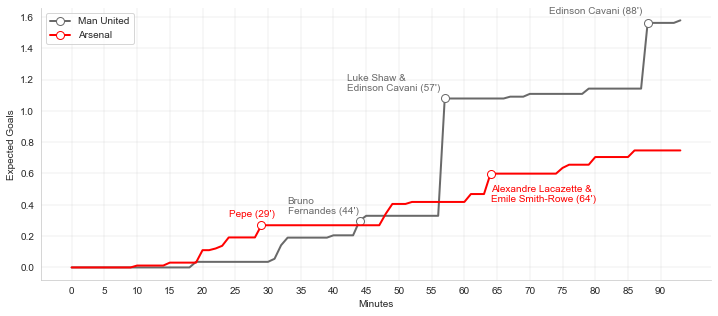

In [5]:
sns.set_style('whitegrid')
sns.set_context(rc={"grid.linewidth": 0.3})
fig = plt.figure(figsize=[12,5])
plt.plot(mu_new_df.loc[:,'xG'], label="Man United", color='dimgrey', linewidth=2,
         marker='o', markerfacecolor='white', markersize=8,
         markevery=[57, 88, 44])
plt.plot(ars_new_df.loc[:,'xG'], label="Arsenal", color='red', linewidth=2,
         marker='o', markerfacecolor='white', markersize=8,
         markevery=[64, 29])
plt.ylabel("Expected Goals")
plt.xlabel("Minutes")
plt.xticks(list(range(0,93,5)))
plt.text(29-5, 0.077803+0.25, "Pepe (29')", color='red', fontsize=10)
plt.text(64, 0.018628+0.4, "Alexandre Lacazette &\nEmile Smith-Rowe (64')", color='red', fontsize=10)
plt.text(44-11, 0.093740+0.25, "Bruno\nFernandes (44')", color='dimgrey', fontsize=10)
plt.text(57-15, 0.749035+0.38, "Luke Shaw &\nEdinson Cavani (57')", color='dimgrey', fontsize=10)
plt.text(88-15, 0.419642+1.2, "Edinson Cavani (88')", color='dimgrey', fontsize=10)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.legend()
#plt.savefig('cavanitax.png', bbox_inches='tight') # save figure
plt.show()